In [1]:
!pip install tensorflow
!pip install matplotlib
!pip install keras

/bin/bash: /media/lyonbach/work/Projects/rim-identifier/venv/bin/pip: /media/lyonbach/work/Repositories/Sandbox/rim-identifier/venv/bin/python3: bad interpreter: No such file or directory
/bin/bash: /media/lyonbach/work/Projects/rim-identifier/venv/bin/pip: /media/lyonbach/work/Repositories/Sandbox/rim-identifier/venv/bin/python3: bad interpreter: No such file or directory
/bin/bash: /media/lyonbach/work/Projects/rim-identifier/venv/bin/pip: /media/lyonbach/work/Repositories/Sandbox/rim-identifier/venv/bin/python3: bad interpreter: No such file or directory


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2024-01-09 23:07:35.106211: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-09 23:07:35.106249: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-09 23:07:35.114534: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-09 23:07:35.187684: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-09 23:07:36.050671: W tensorflow/compiler/tf2

In [3]:
def get_prediction(yhat):

    # return ["rose", "tulip"][yhat.index(1)]
    return ["rose", "tulip"][np.argmax(yhat[0])]


In [4]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1" Uncomment if you want to use CPU only

In [5]:
# Limit GPU memory usage
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
     tf.config.experimental.set_memory_growth(gpu, True)

2024-01-09 23:07:37.060511: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-09 23:07:37.239408: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-09 23:07:37.239629: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Here we could clean the dataset or do some other adjustments if necessary.

In [6]:
# Load data
data = tf.keras.utils.image_dataset_from_directory("../dataset").map(lambda x, y: (x/255.0 , y))
# Hot encode labels for four classes
data = data.map(lambda x, y: (x, tf.one_hot(y, 2)))
iterator = data.as_numpy_iterator()

Found 1768 files belonging to 2 classes.


2024-01-09 23:07:37.344967: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-09 23:07:37.345314: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-09 23:07:37.345588: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [7]:
batch = iterator.next()


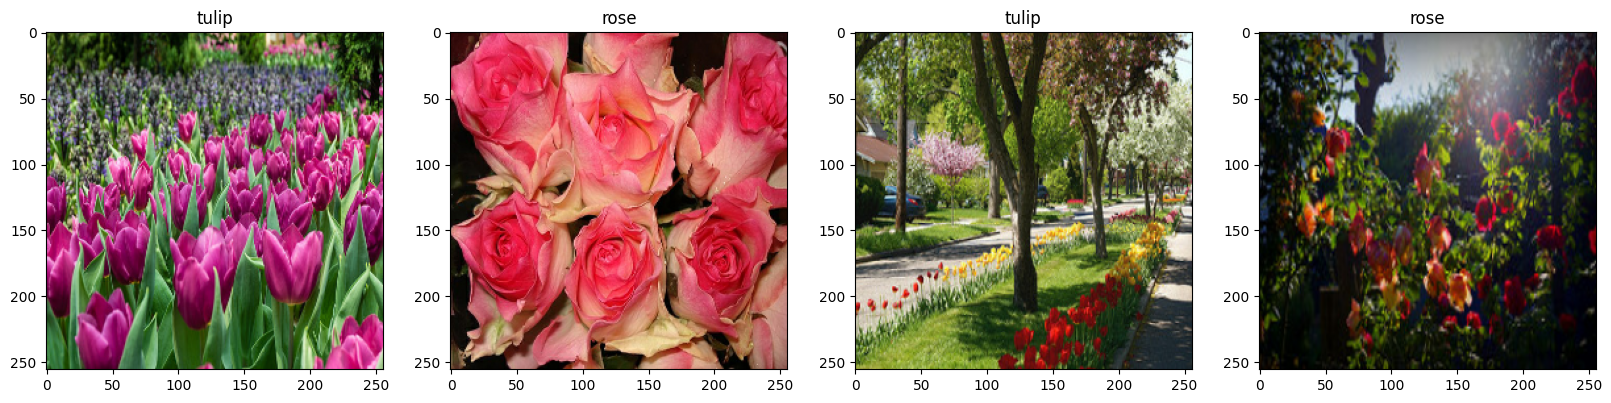

In [8]:
fig, axs = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    axs[idx].imshow(img)
    axs[idx].set_title(["rose", "tulip", ][list(batch[1][idx]).index(1)])
    

2. Split the data

In [9]:
train_size = int(len(data) * 0.8)
val_size = int(len(data) * 0.1) + 1
test_size = int(len(data) * 0.1) + 1

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(test_size + val_size).take(test_size)

3. Build The Deep Learning Model

In [10]:
assert train_size + val_size + test_size == len(data)
assert len(train) > 0
assert len(val) > 0
assert len(test) > 0

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

In [24]:
model = Sequential([

    Conv2D(16, 3, 1, activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D(),

    Conv2D(32, 3, 1, activation='relu'),
    MaxPooling2D(),

    Conv2D(16, 3, 1, activation='relu'),
    MaxPooling2D(),

    Conv2D(8, 3, 1, activation='relu'),
    MaxPooling2D(),

    Flatten(),

    Dense(256, activation='relu',),

    Dense(2, activation='softmax')
])

# model.compile(optimizer='adam',
#               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#               metrics=['accuracy'])
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 30, 30, 16)       

4. Train The Model

In [26]:
log_dir = "../logs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


/media/lyonbach/work/Projects/rim-identifier/venv/lib/python3.10/site-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


44/44 [==============================] - 4s 49ms/step - loss: 0.7005 - accuracy: 0.5298 - val_loss: 0.6881 - val_accuracy: 0.5208


2024-01-09 23:09:13.878382: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 2/20
44/44 [==============================] - 2s 52ms/step - loss: 0.6778 - accuracy: 0.5653 - val_loss: 0.6586 - val_accuracy: 0.5781
Epoch 3/20


2024-01-09 23:09:16.362726: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


44/44 [==============================] - 2s 54ms/step - loss: 0.6370 - accuracy: 0.6193 - val_loss: 0.6030 - val_accuracy: 0.6823


2024-01-09 23:09:18.856400: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 4/20
44/44 [==============================] - 2s 51ms/step - loss: 0.6053 - accuracy: 0.6435 - val_loss: 0.5620 - val_accuracy: 0.7031


2024-01-09 23:09:21.249582: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 5/20
44/44 [==============================] - 2s 52ms/step - loss: 0.5782 - accuracy: 0.6818 - val_loss: 0.6196 - val_accuracy: 0.6823
Epoch 6/20


2024-01-09 23:09:23.688027: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


44/44 [==============================] - 2s 52ms/step - loss: 0.5498 - accuracy: 0.7152 - val_loss: 0.5746 - val_accuracy: 0.6562


2024-01-09 23:09:26.075682: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 7/20
44/44 [==============================] - 2s 53ms/step - loss: 0.4920 - accuracy: 0.7578 - val_loss: 0.4932 - val_accuracy: 0.7448


2024-01-09 23:09:28.548516: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 8/20
43/44 [============================>.] - ETA: 0s - loss: 0.4435 - accuracy: 0.7827

2024-01-09 23:09:30.976279: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


44/44 [==============================] - 2s 52ms/step - loss: 0.4442 - accuracy: 0.7834 - val_loss: 0.4755 - val_accuracy: 0.7865
Epoch 9/20
44/44 [==============================] - 2s 54ms/step - loss: 0.4369 - accuracy: 0.7947 - val_loss: 0.4688 - val_accuracy: 0.7500


2024-01-09 23:09:33.491435: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 10/20
44/44 [==============================] - 2s 51ms/step - loss: 0.3912 - accuracy: 0.8288 - val_loss: 0.4482 - val_accuracy: 0.7917


2024-01-09 23:09:35.903542: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 11/20
44/44 [==============================] - 2s 51ms/step - loss: 0.3398 - accuracy: 0.8608 - val_loss: 0.4519 - val_accuracy: 0.7812


2024-01-09 23:09:38.361339: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 12/20
44/44 [==============================] - 2s 51ms/step - loss: 0.2682 - accuracy: 0.8920 - val_loss: 0.5332 - val_accuracy: 0.7656


2024-01-09 23:09:40.941372: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 13/20
44/44 [==============================] - 2s 53ms/step - loss: 0.2244 - accuracy: 0.9034 - val_loss: 0.7381 - val_accuracy: 0.6875


2024-01-09 23:09:43.363916: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 14/20
44/44 [==============================] - 2s 51ms/step - loss: 0.1860 - accuracy: 0.9276 - val_loss: 0.4713 - val_accuracy: 0.7969


2024-01-09 23:09:45.810160: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 15/20
44/44 [==============================] - 2s 53ms/step - loss: 0.1481 - accuracy: 0.9396 - val_loss: 0.5042 - val_accuracy: 0.8333


2024-01-09 23:09:48.254200: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 16/20
44/44 [==============================] - 2s 51ms/step - loss: 0.1425 - accuracy: 0.9503 - val_loss: 0.3437 - val_accuracy: 0.8802


2024-01-09 23:09:50.585962: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 17/20
43/44 [============================>.] - ETA: 0s - loss: 0.1017 - accuracy: 0.9666

2024-01-09 23:09:52.995570: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


44/44 [==============================] - 2s 52ms/step - loss: 0.1076 - accuracy: 0.9638 - val_loss: 0.4896 - val_accuracy: 0.8438
Epoch 18/20
44/44 [==============================] - 2s 52ms/step - loss: 0.0835 - accuracy: 0.9744 - val_loss: 0.5993 - val_accuracy: 0.8281


2024-01-09 23:09:55.487087: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 19/20
44/44 [==============================] - 2s 53ms/step - loss: 0.0816 - accuracy: 0.9751 - val_loss: 0.5383 - val_accuracy: 0.8594


2024-01-09 23:09:57.918272: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 20/20
44/44 [==============================] - ETA: 0s - loss: 0.0574 - accuracy: 0.9815

2024-01-09 23:10:00.393794: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


44/44 [==============================] - 2s 53ms/step - loss: 0.0574 - accuracy: 0.9815 - val_loss: 0.3112 - val_accuracy: 0.9062


5. Plot the Performance

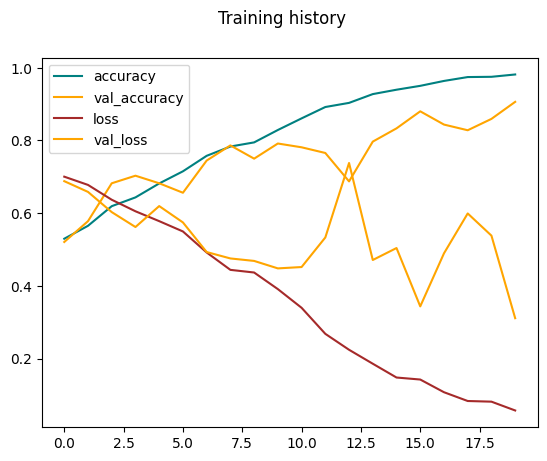

In [27]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
plt.plot(hist.history['loss'], color='brown', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
plt.legend(loc='upper left')
fig.suptitle('Training history')
plt.show()

6. Evaluation

In [28]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [29]:
pre = Precision()
rec = Recall()
acc = BinaryAccuracy()


In [30]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    rec.update_state(y, yhat)
    acc.update_state(y, yhat)

2024-01-09 23:10:10.516720: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 [==============================] - 0s 23ms/step


In [31]:
print("Precision: ", pre.result().numpy())
print("Recall: ", rec.result().numpy())
print("Accuracy: ", acc.result().numpy())

Precision:  0.9895833
Recall:  0.9895833
Accuracy:  0.9895833


7. Test

In [38]:
import cv2
image_path = "../archive/flowers/outer/960x0.webp"
# image_path = "../archive/flowers/outer/tulip-care-guide-hero._TTW_._CR434,0,2133,1200_._SR1500,844_._QL100_.jpg"
# image_path = "../archive/flowers/outer/EMMIEGRAY_MWH_CLASSIC_INFINITY_VIBRANTRED_600x600.png"
# image_path = "../archive/flowers/outer/purple-rose.jpg"
image = cv2.imread(image_path)

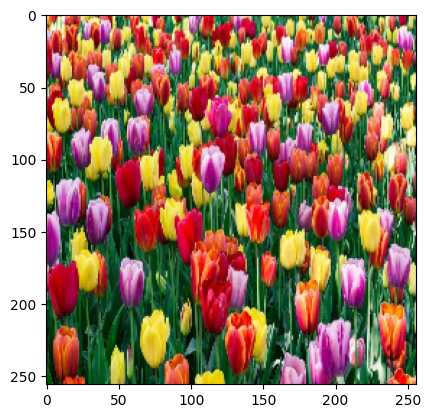

In [39]:
resized = cv2.resize(image, (256, 256))
# change color space
plt.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
plt.show()

8. Prediction

In [40]:
yhat = model.predict(np.expand_dims(resized/255.0, 0))
print(yhat)
print(np.argmax(yhat[0]))
print(get_prediction(yhat))

1/1 [==============================] - 0s 13ms/step
[[1.7961324e-04 9.9982041e-01]]
1
tulip


9. Save The Model

In [23]:
# model.save("models/rose_tulip.h5")